In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import obspy
from obspy.signal.rotate import rotate_ne_rt
from obspy.clients.fdsn import Client as FDSN_Client
from obspy.geodetics import base
from obspy.taup import TauPyModel

import pyproj

In [2]:
auspass = FDSN_Client('http://auspass.edu.au:8080')
inv = auspass.get_stations(network="2B", level='response')
model = TauPyModel(model="iasp91")
geodesic = pyproj.Geod(ellps='WGS84')

locations = {}
for station in inv[0]:
    locations[station.code] = (station.latitude, station.longitude)

station_pairs = []
for i, station in enumerate(inv[0]):
    if station.code in ['SIS01', 'SIS05']:
        continue
    for j in range(i+1, len(inv[0])):
        d = base.gps2dist_azimuth(inv[0][i].latitude, inv[0][i].longitude, 
                                  inv[0][j].latitude, inv[0][j].longitude)[0]
        if d <= 150:
            print('Distance between {} and {}: {:.2f} meters'.format(inv[0][i].code, inv[0][j].code, d))
            station_pairs.append((inv[0][i].code, inv[0][j].code))

Distance between SIS02 and SIS11: 97.99 meters
Distance between SIS03 and SIS14: 68.28 meters
Distance between SIS03 and SIS18: 99.75 meters
Distance between SIS11 and SIS12: 115.23 meters
Distance between SIS12 and SIS13: 94.30 meters
Distance between SIS13 and SIS21: 106.61 meters
Distance between SIS14 and SIS15: 119.87 meters
Distance between SIS15 and SIS16: 103.34 meters
Distance between SIS16 and SIS17: 128.15 meters
Distance between SIS17 and SIS23: 101.71 meters
Distance between SIS18 and SIS19: 98.30 meters
Distance between SIS19 and SIS20: 109.20 meters
Distance between SIS19 and SIS22: 128.05 meters
Distance between SIS20 and SIS21: 145.56 meters
Distance between SIS20 and SIS22: 73.45 meters
Distance between SIS23 and SIS24: 101.66 meters
Distance between SIS25 and SIS26: 105.40 meters
Distance between SIS26 and SIS27: 93.23 meters
Distance between SIS28 and SIS29: 109.40 meters


In [3]:
strain_rates = np.zeros((19,3,9000))

st = obspy.read('../data/waveforms/2023p815812.mseed')

for i, (station1, station2) in enumerate(station_pairs):
    
    lat1 = locations[station1][0]
    lon1 = locations[station1][1]

    idx1 = list(locations.keys()).index(station1)
    north1 = st[3*idx1].data[:9000]    # station 1 north component
    east1 = st[3*idx1+1].data[:9000]   # station 1 east component

    lat2 = locations[station2][0]
    lon2 = locations[station2][1]
    idx2 = list(locations.keys()).index(station2)
    north2 = st[3*idx2].data[:9000]    # station 2 north component
    east2 = st[3*idx2+1].data[:9000]   # station 2 east component

    # Calculate the back azimuth and distance between the two stations
    _, back_azimuth, distance_in_m = geodesic.inv(lon1, lat1, lon2, lat2)

    # Rotate the waveforms to the radial component
    radial1, _ = rotate_ne_rt(north1, east1, back_azimuth % 360)
    radial2, _ = rotate_ne_rt(north2, east2, back_azimuth % 360)

    strain_rates[i,0] = radial1
    strain_rates[i,1] = radial2
    strain_rates[i,2] = (radial1 - radial2) / distance_in_m

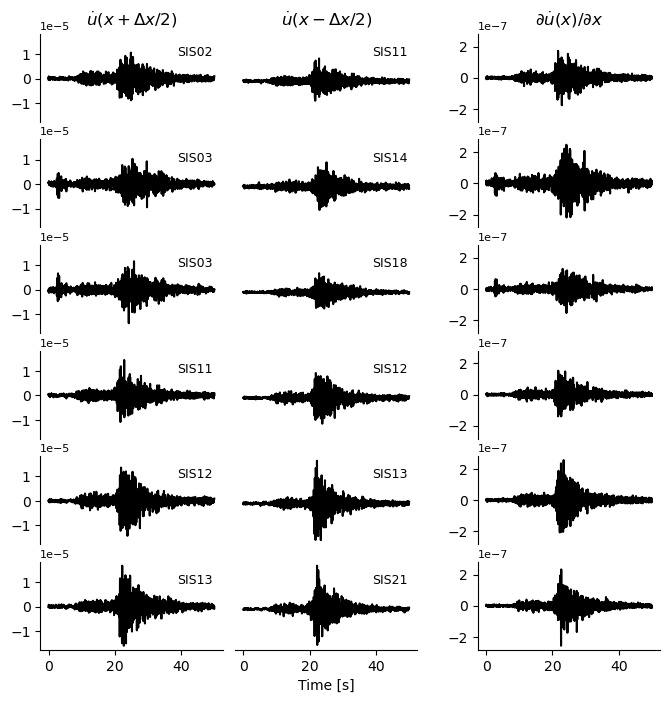

In [4]:
fig, axs = plt.subplots(6, 3, sharey='col', figsize=(8,8))

for i in range(6):
    for j in range(3):
        axs[i,j].plot(np.arange(2500), strain_rates[i,j,5500:8000], color='k')
        
        if j == 0 or j == 2:
            axs[i,j].yaxis.get_offset_text().set_size(8)
        
        if j == 1:
            pos = axs[i,j].get_position()
            axs[i,j].set_position([pos.x0 - 0.03, pos.y0, pos.width, pos.height])
    
    axs[i,0].text(0.75, 0.75, station_pairs[i][0], transform=axs[i,0].transAxes, fontsize=9)
    axs[i,1].text(0.75, 0.75, station_pairs[i][1], transform=axs[i,1].transAxes, fontsize=9)
    
    if i < 5:
        axs[i,0].set_xticks([])
        axs[i,1].set_xticks([])
        axs[i,2].set_xticks([])
    axs[i,1].set_yticks([])
    axs[i,0].spines[['right', 'top', 'bottom']].set_visible(False)
    axs[i,1].spines[['right', 'left', 'top', 'bottom']].set_visible(False)
    axs[i,2].spines[['right', 'top', 'bottom']].set_visible(False)
axs[-1,0].spines[['bottom']].set_visible(True)
axs[-1,1].spines[['bottom']].set_visible(True)
axs[-1,2].spines[['bottom']].set_visible(True)

axs[0,0].set_title(r"$\dot u(x + \Delta x/2)$")
axs[0,1].set_title(r"$\dot u(x - \Delta x/2)$")
axs[0,2].set_title(r"$\partial \dot u(x) / \partial x$")

axs[-1,1].set_xlabel('Time [s]')

axs[-1,0].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x) / 50))}'))
axs[-1,1].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x) / 50))}'))
axs[-1,2].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x) / 50))}'))

plt.savefig('./out/figure_A1.pdf', bbox_inches='tight')
plt.show()